In [80]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import numpy as np
import matplotlib

path = '/Users/Alice/Dropbox/PhD UNITO/Strava Project/data_and_notebook/'
os.chdir(path)

In [88]:
matplotlib.rcParams.update({'font.size': 18, 'font.style': 'normal', 'font.family':'Arial'})
plt.rc('font', family='Arial') 

my_col4=(0.949, 0.839, 0.467)
my_col5=(0.325, 0.529, 0.659)
my_col6=(0.141, 0.259, 0.42)



In [2]:
city_name_dict={'sheffield': 'Sheffield', 'bristol': 'Bristol', 'leeds': 'Leeds', 'plymouth':'Plymouth', 
            'nottingham': 'Nottingham', 'york': 'York', 'manchester': 'Manchester', 
           'exeter': 'Exeter', 'southampton': 'Southampton', 'newcastle upon tyne': 'Newcastle upon Tyne', 
           'norwich':'Norwich', 'derby': 'Derby', 'reading':'Reading', 'london': 'London',
           'phoenix': 'Phoenix', 'sanantonio':'San Antonio',  'austin': 'Austin',
           'jacksonville': 'Jacksonville',
           'charlotte': 'Charlotte', 'boston': 'Boston',
           'nashville': 'Nashville', 'memphis': 'Memphis','oklahomacity': 'Oklahomacity','lasvegas':'Las Vegas',
           'albuquerque': 'Albuquerque','turin': 'Turin', 'rome':'Rome', 'genoa': 'Genoa', 'palermo': 'Palermo',
           'bologna': 'Bologna', 'florence': 'Florence', 'bari': 'Bari', 'catania': 'Catania','venice':'Venice',
           'verona': 'Verona', 'padua':'Padua', 'trieste': 'Trieste','taranto':'Taranto','brescia': 'Brescia',
           'parma': 'Parma', 'modena': 'Modena', 'prato': 'Prato','reggioemilia': 'Reggio Emilia','antwerp': 'Antwerp',
           'ghent': 'Ghent','charleroi': 'Charleroi','liege': 'Liege', 
           'amsterdam': 'Amsterdam', 'rotterdam_thehague': 'Rotterdam/The Hague',
           'utrecht':'Utrecht','eindhoven': 'Eindhoven','tilburg': 'Tilburg', 'almere': 'Almere','groningen':'Groningen','breda': 'Breda',
           'nijmegen': 'Nijmegen','apeldoorn':'Apeldoorn','haarlem': 'Haarlem','arnhem':'Arnhem',
           'luxembourg':'Luxembourg city', 'louisville': 'Louisville', 'newyork': 'New York'}

df=pd.read_csv(path+'final data/City_level_final_dataset.csv', sep=',')

In [3]:
def segments_filtering(citylevel_average_fem):
    cyclists=range(1,100, 1)
    prob_r=[]
    N_segments=[]
    for i in range(1,100,1):
        prob_r.append((1-average_fem)**i)
        N_segments.append(len(gdf[gdf['total']<i])/len(gdf))
    tol=0.01
    #N starts at 1 but index of list at 0
    for i in range(0, len(prob_r), 1) :
        a=abs(prob_r[i]-prob_r[i+1])
        if a < tol :
            print(i+1) 
            threshold_total = i+1
            break
        else:
            continue
    return threshold_total

def store_res(model_fit):
    p = model_fit.params
    p_val=model_fit.pvalues
    ci95_l=model_fit.conf_int()[0]
    ci95_u=model_fit.conf_int()[1]
    results_table = pd.DataFrame([p, p_val, ci95_l, ci95_u]).T.rename(columns={'Unnamed 0': "parameters",  'Unnamed 1': 'p values', 0: 'ci95_lower', 1: 'ci95_upper'})

    results_table['significance']=results_table.apply(lambda x: 1 if  x['p values']<0.05 else 0 , axis=1)       
    results_table=results_table.sort_values(by='parameters').reset_index(drop=False)
    results_table['ind']=results_table.index
    return results_table

In [18]:
results={25:{},
        33:{},
        40:{}}
accuracies={25:{},
        33:{},
        40:{}}
gender_ratio={}
macro_area={}
observations={}

for city in city_name_dict.keys():
        print(city)
        if city!='newyork':
            gdf=gpd.read_file(path+'final data/Projection to OSMNX_GHS definitions/final_'+city+'.shp')
        else:
            gdf=gpd.read_file(path+'final data/Projection to OSMNX/final_'+city+'_ready_for_analysis.shp')

        gdf['ratio']=gdf['female']/gdf['total']

        # Identify threshold for filtering
        average_fem=gdf.female.sum()/gdf.total.sum()
        threshold_total=segments_filtering(average_fem)

        gdf=gdf[gdf['total']>threshold_total]
        # Generate dummies
        gdf['Protected']=0
        gdf.loc[gdf['protection']=='Protected', 'Protected']=1
        gdf['Unprotected']=0
        gdf.loc[gdf['protection']=='Unprotected', 'Unprotected']=1

        # Logisitc Regression
        # Use statsmodel sm instead of 
        #Filter dataset to include only streets belonging to the top and bottom i% of the distribution
        for i in [25, 33, 40]:
            try: #FOr a few combination, matrix ingularity
                dataset_two=gdf.copy()
                threshold1=np.percentile(dataset_two.ratio, i)
                threshold2=np.percentile(dataset_two.ratio, 100-i)
                dataset_two['ratio_2classified']=dataset_two.apply(lambda x: 0 if x['ratio']<=threshold1 else np.nan, axis=1)
                dataset_two['ratio_2classified']=dataset_two.apply(lambda x: 1 if x['ratio']>=threshold2 else x['ratio_2classified'], axis=1)
                dataset_two=dataset_two[dataset_two['ratio_2classified'].isnull()==False]
                X = dataset_two[['Protected', 'Unprotected']]
                #dependent variable
                y = dataset_two['ratio_2classified']

                log_reg = sm.Logit(y, X).fit()
                print(log_reg.summary())
                observations[city]=log_reg.nobs

                # performing predictions on the test datdaset
                yhat = log_reg.predict(X)
                prediction = list(map(round, yhat))

                # confusion matrix
                cm = confusion_matrix(y, prediction)
                print ("Confusion Matrix : \n", cm)
                # accuracy score of the model
                print('Test accuracy = ', accuracy_score(y, prediction))
                accuracies[i][city]=accuracy_score(y, prediction)
                #Store results in table
                results[i][city]=store_res(log_reg)
            except:
                continue
            gender_ratio[city]=df[df['city']==city_name_dict[city]]['gender_ratio'].values
            macro_area[city]=df[df['city']==city_name_dict[city]]['country'].values


sheffield
23
Optimization terminated successfully.
         Current function value: 0.691093
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 8287
Model:                          Logit   Df Residuals:                     8285
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.002963
Time:                        17:35:10   Log-Likelihood:                -5727.1
converged:                       True   LL-Null:                       -5744.1
Covariance Type:            nonrobust   LLR p-value:                 5.386e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.2033      0.062      3.302      0.001       0.083       0.324
Unprotected  

21
Optimization terminated successfully.
         Current function value: 0.692602
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                12136
Model:                          Logit   Df Residuals:                    12134
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:               0.0007861
Time:                        17:37:13   Log-Likelihood:                -8405.4
converged:                       True   LL-Null:                       -8412.0
Covariance Type:            nonrobust   LLR p-value:                 0.0002762
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.1138      0.047      2.407      0.016       0.021       0.207
Unprotected    -0.3245 

20
Optimization terminated successfully.
         Current function value: 0.660615
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 4414
Model:                          Logit   Df Residuals:                     4412
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.04693
Time:                        17:38:07   Log-Likelihood:                -2916.0
converged:                       True   LL-Null:                       -3059.5
Covariance Type:            nonrobust   LLR p-value:                 2.047e-64
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       1.2110      0.078     15.513      0.000       1.058       1.364
Unprotected    -0.0606 

manchester
20
Optimization terminated successfully.
         Current function value: 0.687714
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 6677
Model:                          Logit   Df Residuals:                     6675
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.007839
Time:                        17:39:11   Log-Likelihood:                -4591.9
converged:                       True   LL-Null:                       -4628.1
Covariance Type:            nonrobust   LLR p-value:                 1.623e-17
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.2630      0.061      4.297      0.000       0.143       0.383
Unprotected 

21
Optimization terminated successfully.
         Current function value: 0.679776
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 4007
Model:                          Logit   Df Residuals:                     4005
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.01929
Time:                        17:39:44   Log-Likelihood:                -2723.9
converged:                       True   LL-Null:                       -2777.4
Covariance Type:            nonrobust   LLR p-value:                 4.116e-25
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected      -0.0840      0.087     -0.961      0.337      -0.255       0.087
Unprotected    -0.9456 

19
Optimization terminated successfully.
         Current function value: 0.687789
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 2517
Model:                          Logit   Df Residuals:                     2515
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.007730
Time:                        17:40:10   Log-Likelihood:                -1731.2
converged:                       True   LL-Null:                       -1744.7
Covariance Type:            nonrobust   LLR p-value:                 2.065e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.2932      0.080      3.666      0.000       0.136       0.450
Unprotected    -0.6487 

21
Optimization terminated successfully.
         Current function value: 0.686901
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 2071
Model:                          Logit   Df Residuals:                     2069
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.009010
Time:                        17:40:28   Log-Likelihood:                -1422.6
converged:                       True   LL-Null:                       -1435.5
Covariance Type:            nonrobust   LLR p-value:                 3.654e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.4679      0.095      4.937      0.000       0.282       0.654
Unprotected     0.1283 

Confusion Matrix : 
 [[20886  2814]
 [20021  3683]]
Test accuracy =  0.5182895958146991
phoenix
20
Optimization terminated successfully.
         Current function value: 0.659641
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 6534
Model:                          Logit   Df Residuals:                     6532
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.04834
Time:                        17:42:00   Log-Likelihood:                -4310.1
converged:                       True   LL-Null:                       -4529.0
Covariance Type:            nonrobust   LLR p-value:                 3.159e-97
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protect

17
Optimization terminated successfully.
         Current function value: 0.678465
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 9252
Model:                          Logit   Df Residuals:                     9250
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.02118
Time:                        17:42:52   Log-Likelihood:                -6277.2
converged:                       True   LL-Null:                       -6413.0
Covariance Type:            nonrobust   LLR p-value:                 4.905e-61
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected      -0.6672      0.053    -12.686      0.000      -0.770      -0.564
Unprotected     0.4137 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


         Current function value: 0.677626
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  852
Model:                          Logit   Df Residuals:                      850
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.02183
Time:                        17:43:08   Log-Likelihood:                -577.34
converged:                      False   LL-Null:                       -590.22
Covariance Type:            nonrobust   LLR p-value:                 3.842e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected     -28.3141   4.06e+05  -6.97e-05      1.000   -7.96e+05    7.96e+05
Unprotected    -0.6232      0.204     -3.058      0.002      -

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Optimization terminated successfully.
         Current function value: 0.687667
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1087
Model:                          Logit   Df Residuals:                     1085
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.007901
Time:                        17:43:08   Log-Likelihood:                -747.49
converged:                       True   LL-Null:                       -753.45
Covariance Type:            nonrobust   LLR p-value:                 0.0005597
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected      -1.7918      0.764     -2.346      0.019      -3.289      -0.295
Unprotected    -0.3646    

Optimization terminated successfully.
         Current function value: 0.678481
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 5894
Model:                          Logit   Df Residuals:                     5892
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.02116
Time:                        17:43:29   Log-Likelihood:                -3999.0
converged:                       True   LL-Null:                       -4085.4
Covariance Type:            nonrobust   LLR p-value:                 1.734e-39
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       1.1113      0.092     12.078      0.000       0.931       1.292
Unprotected    -0.0823    

Optimization terminated successfully.
         Current function value: 0.681295
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1457
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.01707
Time:                        17:43:40   Log-Likelihood:                -994.01
converged:                       True   LL-Null:                       -1011.3
Covariance Type:            nonrobust   LLR p-value:                 4.197e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       1.0609      0.193      5.486      0.000       0.682       1.440
Unprotected     0.0392    

Optimization terminated successfully.
         Current function value: 0.689851
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 3388
Model:                          Logit   Df Residuals:                     3386
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.004755
Time:                        17:44:01   Log-Likelihood:                -2337.2
converged:                       True   LL-Null:                       -2348.4
Covariance Type:            nonrobust   LLR p-value:                 2.294e-06
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.7102      0.160      4.429      0.000       0.396       1.025
Unprotected     0.3677    

Optimization terminated successfully.
         Current function value: 0.692378
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 4863
Model:                          Logit   Df Residuals:                     4861
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.001107
Time:                        17:44:17   Log-Likelihood:                -3367.0
converged:                       True   LL-Null:                       -3370.8
Covariance Type:            nonrobust   LLR p-value:                  0.006306
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.1201      0.063      1.912      0.056      -0.003       0.243
Unprotected     0.2640    

Optimization terminated successfully.
         Current function value: 0.690418
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 5214
Model:                          Logit   Df Residuals:                     5212
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.003936
Time:                        17:44:39   Log-Likelihood:                -3599.8
converged:                       True   LL-Null:                       -3614.1
Covariance Type:            nonrobust   LLR p-value:                 9.624e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected      -0.5219      0.121     -4.297      0.000      -0.760      -0.284
Unprotected     0.5261    

Optimization terminated successfully.
         Current function value: 0.677177
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 2123
Model:                          Logit   Df Residuals:                     2121
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.02304
Time:                        17:44:48   Log-Likelihood:                -1437.6
converged:                       True   LL-Null:                       -1471.5
Covariance Type:            nonrobust   LLR p-value:                 1.803e-16
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.2673      0.087      3.083      0.002       0.097       0.437
Unprotected     1.0396    

Optimization terminated successfully.
         Current function value: 0.685616
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  682
Model:                          Logit   Df Residuals:                      680
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.01086
Time:                        17:44:55   Log-Likelihood:                -467.59
converged:                       True   LL-Null:                       -472.72
Covariance Type:            nonrobust   LLR p-value:                  0.001355
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.1178      0.281      0.420      0.675      -0.432       0.668
Unprotected    -0.7108    

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


         Current function value: 0.679324
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1053
Model:                          Logit   Df Residuals:                     1051
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.01991
Time:                        17:44:56   Log-Likelihood:                -715.33
converged:                      False   LL-Null:                       -729.86
Covariance Type:            nonrobust   LLR p-value:                 6.997e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected      21.5255   1.06e+04      0.002      0.998   -2.07e+04    2.07e+04
Unprotected   -25.1894   2.95e+05  -8.54e-05      1.000   -5.7

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


         Current function value: 0.675627
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1266
Model:                          Logit   Df Residuals:                     1264
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.02527
Time:                        17:44:57   Log-Likelihood:                -855.34
converged:                      False   LL-Null:                       -877.52
Covariance Type:            nonrobust   LLR p-value:                 2.735e-11
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected      26.8117    1.3e+05      0.000      1.000   -2.55e+05    2.55e+05
Unprotected  -538.8208  4.12e+116 -1.31e-114      1.000  -8.07

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


24
Optimization terminated successfully.
         Current function value: 0.679428
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  181
Model:                          Logit   Df Residuals:                      179
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.01977
Time:                        17:44:57   Log-Likelihood:                -122.98
converged:                       True   LL-Null:                       -125.46
Covariance Type:            nonrobust   LLR p-value:                   0.02593
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected      -0.8109      0.425     -1.908      0.056      -1.644       0.022
Unprotected    -0.6931 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Optimization terminated successfully.
         Current function value: 0.627720
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  945
Model:                          Logit   Df Residuals:                      943
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.09439
Time:                        17:44:59   Log-Likelihood:                -593.20
converged:                       True   LL-Null:                       -655.02
Covariance Type:            nonrobust   LLR p-value:                 1.002e-28
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       1.8539      0.211      8.790      0.000       1.441       2.267
Unprotected     1.6740    

Optimization terminated successfully.
         Current function value: 0.679276
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1483
Model:                          Logit   Df Residuals:                     1481
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.01996
Time:                        17:45:04   Log-Likelihood:                -1007.4
converged:                       True   LL-Null:                       -1027.9
Covariance Type:            nonrobust   LLR p-value:                 1.500e-10
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       1.2278      0.211      5.815      0.000       0.814       1.642
Unprotected     0.6931    

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


         Current function value: 0.624979
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  304
Model:                          Logit   Df Residuals:                      302
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.09427
Time:                        17:45:10   Log-Likelihood:                -189.99
converged:                      False   LL-Null:                       -209.77
Covariance Type:            nonrobust   LLR p-value:                 3.199e-10
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected      -0.4336      0.153     -2.826      0.005      -0.734      -0.133
Unprotected    18.9232   2624.332      0.007      0.994   -512

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


36
Optimization terminated successfully.
         Current function value: 0.649227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643765
         Iterations 5
reggioemilia
35
         Current function value: 0.614976
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  228
Model:                          Logit   Df Residuals:                      226
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                  0.1120
Time:                        17:45:12   Log-Likelihood:                -140.21
converged:                      False   LL-Null:                       -157.90
Covariance Type:            nonrobust   LLR p-value:    

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Optimization terminated successfully.
         Current function value: 0.645504
         Iterations 19
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  294
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.06870
Time:                        17:45:12   Log-Likelihood:                -189.78
converged:                       True   LL-Null:                       -203.78
Covariance Type:            nonrobust   LLR p-value:                 1.213e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.7673      0.168      4.572      0.000       0.438       1.096
Unprotected   -38.3202   

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


23
Optimization terminated successfully.
         Current function value: 0.688003
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 2515
Model:                          Logit   Df Residuals:                     2513
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.007412
Time:                        17:45:15   Log-Likelihood:                -1730.3
converged:                       True   LL-Null:                       -1743.2
Covariance Type:            nonrobust   LLR p-value:                 3.708e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.1314      0.049      2.660      0.008       0.035       0.228
Unprotected     0.7862 

30
Optimization terminated successfully.
         Current function value: 0.689514
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  576
Model:                          Logit   Df Residuals:                      574
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.005025
Time:                        17:45:27   Log-Likelihood:                -397.16
converged:                       True   LL-Null:                       -399.17
Covariance Type:            nonrobust   LLR p-value:                   0.04519
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.4520      0.279      1.619      0.105      -0.095       0.999
Unprotected    -0.4308 

16
Optimization terminated successfully.
         Current function value: 0.690392
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 4502
Model:                          Logit   Df Residuals:                     4500
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.003958
Time:                        17:45:37   Log-Likelihood:                -3108.1
converged:                       True   LL-Null:                       -3120.5
Covariance Type:            nonrobust   LLR p-value:                 6.696e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.0405      0.037      1.093      0.274      -0.032       0.113
Unprotected     0.4581 

16
Optimization terminated successfully.
         Current function value: 0.687341
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 2584
Model:                          Logit   Df Residuals:                     2582
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.008377
Time:                        17:45:57   Log-Likelihood:                -1776.1
converged:                       True   LL-Null:                       -1791.1
Covariance Type:            nonrobust   LLR p-value:                 4.305e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.0752      0.054      1.397      0.162      -0.030       0.181
Unprotected    -0.5157 

20
Optimization terminated successfully.
         Current function value: 0.675420
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  936
Model:                          Logit   Df Residuals:                      934
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.02555
Time:                        17:46:07   Log-Likelihood:                -632.19
converged:                       True   LL-Null:                       -648.77
Covariance Type:            nonrobust   LLR p-value:                 8.543e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.5455      0.102      5.369      0.000       0.346       0.745
Unprotected     0.3137 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


         Current function value: 0.668911
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1162
Model:                          Logit   Df Residuals:                     1160
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.03496
Time:                        17:46:10   Log-Likelihood:                -777.27
converged:                      False   LL-Null:                       -805.44
Covariance Type:            nonrobust   LLR p-value:                 6.156e-14
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.2478      0.068      3.640      0.000       0.114       0.381
Unprotected   -22.8599   1.65e+04     -0.001      0.999   -3.2

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


         Current function value: 0.671059
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1412
Model:                          Logit   Df Residuals:                     1410
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.03184
Time:                        17:46:11   Log-Likelihood:                -947.54
converged:                      False   LL-Null:                       -978.70
Covariance Type:            nonrobust   LLR p-value:                 2.902e-15
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.2703      0.062      4.385      0.000       0.149       0.391
Unprotected   -21.3116   7622.084     -0.003      0.998    -1.

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


14
Optimization terminated successfully.
         Current function value: 0.688042
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1280
Model:                          Logit   Df Residuals:                     1278
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.007365
Time:                        17:46:12   Log-Likelihood:                -880.69
converged:                       True   LL-Null:                       -887.23
Covariance Type:            nonrobust   LLR p-value:                 0.0003001
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected      -0.0956      0.079     -1.216      0.224      -0.250       0.058
Unprotected     0.5730 

17
Optimization terminated successfully.
         Current function value: 0.674302
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1053
Model:                          Logit   Df Residuals:                     1051
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.02719
Time:                        17:46:17   Log-Likelihood:                -710.04
converged:                       True   LL-Null:                       -729.88
Covariance Type:            nonrobust   LLR p-value:                 2.981e-10
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.5646      0.096      5.878      0.000       0.376       0.753
Unprotected    -0.2683 

17
Optimization terminated successfully.
         Current function value: 0.641195
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                  513
Model:                          Logit   Df Residuals:                      511
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.07438
Time:                        17:46:21   Log-Likelihood:                -328.93
converged:                       True   LL-Null:                       -355.37
Covariance Type:            nonrobust   LLR p-value:                 3.574e-13
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.6758      0.132      5.131      0.000       0.418       0.934
Unprotected    -1.2611 

24
Optimization terminated successfully.
         Current function value: 0.689554
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                 1047
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                0.005178
Time:                        17:46:28   Log-Likelihood:                -721.96
converged:                       True   LL-Null:                       -725.72
Covariance Type:            nonrobust   LLR p-value:                  0.006117
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       0.3039      0.112      2.708      0.007       0.084       0.524
Unprotected     0.0541 

18
Optimization terminated successfully.
         Current function value: 0.652763
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                12893
Model:                          Logit   Df Residuals:                    12891
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                 0.05826
Time:                        17:46:52   Log-Likelihood:                -8416.1
converged:                       True   LL-Null:                       -8936.7
Covariance Type:            nonrobust   LLR p-value:                1.850e-228
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Protected       1.1635      0.058     20.133      0.000       1.050       1.277
Unprotected     0.8544 

In [32]:
gender_ratio_df=pd.DataFrame({'city':list(gender_ratio.keys()), 'gender_ratio':list(gender_ratio.values())})
gender_ratio_df['gender_ratio']=gender_ratio_df['gender_ratio'].apply(lambda x: x[0])
gender_ratio_df['city_label']=gender_ratio_df['city'].apply(lambda x: city_name_dict[x])

macro_area_df=pd.DataFrame({'city':list(macro_area.keys()), 'country':list(macro_area.values())})
macro_area_df['country']=macro_area_df['country'].apply(lambda x: x[0])
macro_area_df.loc[macro_area_df['country'].isin(['Italy', 'UK', 'US'])==False,'country']='Benelux'

sorting_df=pd.merge(gender_ratio_df,macro_area_df, on='city')

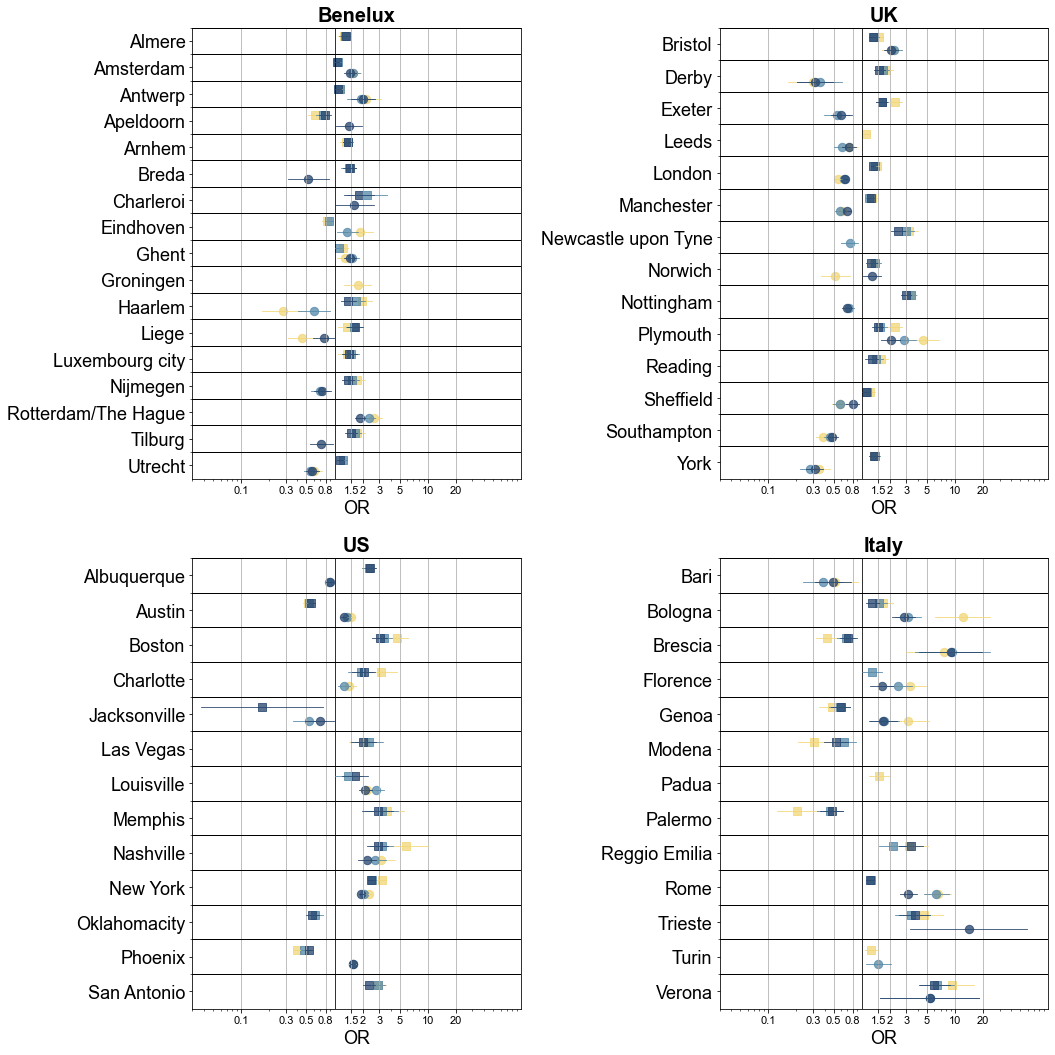

In [146]:
pos_adjustment={'Protected':+0.2 , 'Unprotected':-0.2}
colors={25:my_col4, 33:my_col5, 40: my_col6}
markers={'Protected':'s', 'Unprotected':'o' }

fig=plt.figure(figsize=(15,15))
for icoun,country in enumerate(['Benelux', 'UK', 'US', 'Italy']):
    ax=plt.subplot(2,2, icoun+1)
    ax.set_title(country, size=20, fontweight='bold')
    sorting_df_tmp=sorting_df.sort_values('city', ascending=False).copy()
    sorting_df_tmp=sorting_df_tmp[sorting_df_tmp['country']==country]
    
    ax.set_xscale('log')
    ax.grid(axis='y', which='minor', linestyle='solid', linewidth=1, color='black')
    ax.grid(axis='y', which='major',linewidth=0)
    ax.grid(axis='x', which='major')
    ax.set_xlim([0.03,100])
    ax.axvline(1, 0, 20, color='black', linewidth=0.8)
    
    ax.set_xticks([0.1, 0.3, 0.5, 0.8,1.5, 2, 3, 5, 10, 20])
    ax.set_xticklabels([0.1, 0.3, 0.5, 0.8, 1.5,2, 3, 5, 10, 20], size=11)
    
    indc=0
    cities_label=[]
    for city in sorting_df_tmp[sorting_df_tmp['country']==country]['city']:
        if results[25][city]['significance'].max()+results[33][city]['significance'].max()+results[40][city]['significance'].max()>0:
            cities_label.append(city_name_dict[city])
            for alpha in [25, 33, 40]:
                results_table=results[alpha][city].copy()
                for i in ['Protected', 'Unprotected']:
                    if results_table[results_table['index']==i]['significance'].values[0]==1:
                        odd_ratio=np.exp(results_table[results_table['index']==i]['parameters'].values[0])
                        ax.scatter(odd_ratio, indc+pos_adjustment[i], s=70, color=colors[alpha], marker=markers[i], alpha=0.75)
                        ax.plot([np.exp(results_table[results_table['index']==i].ci95_lower.values[0]),np.exp(results_table[results_table['index']==i].ci95_upper.values[0])], [indc+pos_adjustment[i], indc+pos_adjustment[i]], color=colors[alpha], linewidth=0.8)      
            indc=indc+1
    
    ax.set_ylim([-0.5, indc-0.5])
    ax.set_yticks(range(len(cities_label)))
    ax.set_yticks([i + 0.5 for i in range(len(cities_label))] , minor=True)
    ax.set_yticklabels(cities_label, size=18)
    ax.set_xlabel('OR', size=18)
        
plt.tight_layout()
plt.savefig("/Users/Alice/Desktop/fig.pdf", pdi=300)